In [ ]:

# @hidden_cell
credentials_1 = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_b6d2dc43_04df_42d5_bf42_5b6ca8af67ff',
  'project_id':'b27f8cf040e5488eb7ceb30211ba0896',
  'region':'dallas',
  'user_id':'ed411c6b7daa4284a2208c6d34cda037',
  'domain_id':'9d54dfb7f46d48d8930e2e61e1e7ddab',
  'domain_name':'1257643',
  'username':'member_6e6fb2aeb2891f1e6518800b3facd7562d18ac79',
  'password':"""Fl^J{l2v*M0cXWqv""",
  'container':'BITCOINTRANSACTIONNETWORKANALYSIS',
  'tenantId':'undefined',
  'filename':'BTC_merged.csv'
}


In [ ]:
def put_file(credentials, local_file_name):  
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage V3."""
    f = open(local_file_name,'r')
    my_data = f.read()
    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', credentials['container'], '/', local_file_name])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.put(url=url2, headers=headers2, data = my_data )
    print (resp2)
    

In [ ]:

from io import StringIO
import requests
import json
import pandas as pd
import numpy as np 

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_b6d2dc4304df42d5bf425b6ca8af67ff(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_6e6fb2aeb2891f1e6518800b3facd7562d18ac79','domain': {'id': '9d54dfb7f46d48d8930e2e61e1e7ddab'},
            'password': 'Fl^J{l2v*M0cXWqv'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)



In [ ]:

df = pd.read_csv(get_object_storage_file_with_credentials_b6d2dc4304df42d5bf425b6ca8af67ff('BITCOINTRANSACTIONNETWORKANALYSIS', 'BTC_merged_all.csv'))
print(df.tail())

In [ ]:

df['transaction_to_trade_ratio_D'] = np.where(df['estimated-transaction-volume-usd'] !=0,df['estimated-transaction-volume'] /df['estimated-transaction-volume-usd'],0)


In [ ]:
# small_df = df.head(5)
# r_count = 0
# for index,row in small_df.iterrows():
#     print(row['market-price-all-time'])
############################################################ 
###### uncomment only when making csv for prediction #######
############################################################
# df_pred = df.drop('estimated-transaction-volume-usd',1)

# df_pred.to_csv("Df_for_Prediction.csv")
# put_file(credentials_1,'Df_for_Prediction.csv') ## after to_csv 
# list(df_pred)

In [ ]:
myarray = np.array(df['market-price'])
d = np.diff(myarray)
diff_price = np.insert(d,0,0)

df['price_diff'] = diff_price.tolist()

df['up_down_same'] = np.where(df['price_diff'] == 0 ,1,np.where(df['price_diff'] > 0, 1,np.where(df['price_diff'] < 0, -1,np.nan)))

print("Y ",value counts)
print(df['up_down_same'].value_counts())

In [ ]:

final = df.drop(['price_diff','estimated-transaction-volume-usd','market-price','time_stamp'], 1)
print("Final CSV with Y ",len(list(final)))


In [ ]:
# final.to_csv("Df_for_Classification.csv")
# put_file(credentials_1,'Df_for_Classification.csv') ## after to_csv 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.preprocessing import LabelEncoder
def dummyEncode(df,y):
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    count=0
    for feature in columnsToEncode:
        try:
            if feature!=y:
                df[feature] = le.fit_transform(df[feature])
            else:
                #print('Hello')
                df[feature] = df[feature]
        except Exception as e:
            print(count,' Error encoding ',df[feature][count],' error: ',e)
        count+=1     
    return df  

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def calculate_roc_curve(Y_test, preds, pos_label):
    
    fpr, tpr, _ = roc_curve(Y_test, preds)
    #Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()


In [47]:
from sklearn.ensemble import RandomForestClassifier

import datetime
def random_forest(X_train,Y_train,X_test,Y_test):
     #Random Forest
#     print("Random Forest")    
    rf = RandomForestClassifier(n_estimators=150, random_state=45)
    y_pred = rf.fit(X_train, Y_train).predict(X_test) ## check later!!
    
    #calculate ROC curve
    preds = rf.predict_proba(X_test)[:,1]
    calculate_roc_curve(Y_test, preds,2)

    cm=confusion_matrix(Y_test, y_pred)
    print(datetime.datetime.now())
    print(" Random Forest cm :: ") 
    print(cm)
    print(" Accuracy Score :: ")
    print(accuracy_score(Y_test, y_pred))
    
#     return cm

In [52]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler 
def neural_network_classifier(X_train,Y_train,X_test,Y_test):
    print("#neural network")
    scaler = StandardScaler()
    # Fit only to the training data
    scaler.fit(X_train)
    X_train_nn = scaler.transform(X_train)
    X_test_nn = scaler.transform(X_test)

    neural_network_class=MLPClassifier(hidden_layer_sizes=(30,20,30))
    neural_network_class.fit(X_train,Y_train)
    predictions = neural_network_class.predict(X_test)
    y_pred=predictions

    #calculate ROC curve
    preds = neural_network_class.predict_proba(X_test)[:,1]
    calculate_roc_curve(Y_test, preds,2)

    cm=confusion_matrix(Y_test, y_pred)
    print(datetime.datetime.now())
    print(" Neural Network cm :: ") 
    print(cm)
    print(" Accuracy Score :: ")
    print(accuracy_score(Y_test, y_pred))
  

In [ ]:
#import math
from sklearn.model_selection import train_test_split
# train_size = math.floor(70/100 * len(final))
# test_size = len(final) - train_size

y = "up_down_same"
X_Enc_y = dummyEncode(final,y)
Y_Enc = X_Enc_y[y]
X_Enc = X_Enc_y.drop(y,1)
 

#random split method for creating the training and test splits
X_train, X_test, Y_train, Y_test = train_test_split(X_Enc,Y_Enc, test_size=0.3)


In [ ]:

#output of feature selection
rfe_delete =['median-confirmation-time',
             'transaction_to_trade_ratio_D',
             'cost-per-transaction',
             'n-orphaned-blocks',
             'avg-block-size']

sel_perc_cols_by_rank = ['total-bitcoins', 'cost-per-transaction', 'median-confirmation-time',
                         'miners-revenue', 'n-orphaned-blocks', 'estimated-transaction-volume', 
                         'n-unique-addresses', 'transaction_to_trade_ratio_D', 
                         'n-transactions-per-block', 'avg-block-size', 'n-transactions',
                         'market-cap', 'difficulty', 'hash-rate', 'transaction-fees']


pearson_low_to_high_neg =[ 
    'transaction-fees',
#     'hash-rate',
#     'difficulty',
#     'transaction_to_trade_ratio_D',
#     'n-transactions',
#     'market-cap',
#     'n-transactions-per-block',
#     'avg-block-size',
#     'estimated-transaction-volume',
#     'n-unique-addresses',
#     'n-orphaned-blocks',
#     'miners-revenue',
#     'median-confirmation-time',
#     'cost-per-transaction',
#     'total-bitcoins'
]

low_to_high_sel_perc = list(reversed(sel_perc_cols_by_rank))
# low_to_high_sel_perc

In [44]:
#### Decide what to keep/drop
X_train_sp = X_train.drop(pearson_low_to_high_neg,1)
X_test_sp = X_test.drop(pearson_low_to_high_neg,1)

In [ ]:

### Used to check combinations of features
# import random
# for i in range(0,3):
    
# random.shuffle(dropping)
# cols = []
# for feature in low_to_high_sel_perc: 
#     cols.append(feature)
#     if(len(cols) != len(low_to_high_sel_perc)):
#         print ("dropping ",cols)
#         X_train_f = X_train.drop(cols,1)
#         X_test_f = X_test.drop(cols,1)

#         random_forest(X_train_f,Y_train,X_test_f,Y_test)

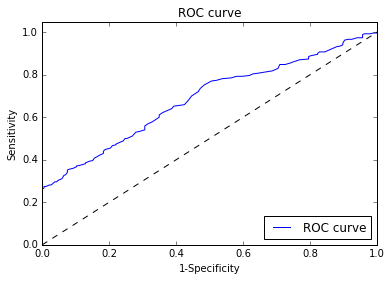

2017-04-28 22:04:41.248723
 Random Forest cm :: 
[[ 98  88]
 [ 71 199]]
 Accuracy Score :: 
0.651315789474


In [48]:
## random forest
X_train_final =X_train_sp
X_test_final =X_test_sp
random_forest(X_train_final,Y_train,X_test_final,Y_test)
# list(X_train_final)

#neural network


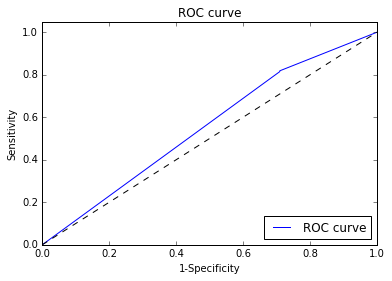

2017-04-28 22:05:41.484058
 Neural Network cm :: 
[[ 54 132]
 [ 49 221]]
 Accuracy Score :: 
0.603070175439


In [53]:
## neural_network
X_train_final =X_train_sp
X_test_final =X_test_sp
neural_network_classifier(X_train_final,Y_train,X_test_final,Y_test)
# list(X_train_final)